# Auto-cross-correlogram

In [1]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
import scipy.signal as signal
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer
from scipy import stats

from one.api import ONE
import matplotlib.pyplot as plt

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from plotting_functions import bins_per_trial_phase

one = ONE()

Downloading: /Users/ineslaranjeira/Downloads/FlatIron/tmp_41krlqf/cache.zip Bytes: 114978767


100%|██████████| 109.6522970199585/109.6522970199585 [00:33<00:00,  3.24it/s]


## Parameters

In [2]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'

data_path = data_path_v2

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

## Preprocess list of design matrices

In [43]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for m, mat in enumerate(design_matrices[0:1]):
    
    # Trials data
    session = design_matrices[m][14:-4]
    
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
    session_trials['trial'] = np.arange(1, len(session_trials)+1)

    time_trial_90 = list(unbiased['stimOff_times'])[-1]
    time_trial_180 = list(session_trials.loc[session_trials['trial']==180, 'stimOff_times'])[-1]
    
    big_design_matrix = pickle.load(open(mat, "rb"))
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    design_matrix = design_matrix.loc[(design_matrix['Bin'] < session_end * 10) & (design_matrix['Bin'] > session_start * 10)]
    
    # Keep only first 90 trials
    # design_matrix = design_matrix.loc[(design_matrix['Bin'] > time_trial_90 * 10) & (design_matrix['Bin'] < time_trial_180 * 10) & (design_matrix['Bin'] > session_start * 10)]
    # design_matrix = design_matrix.loc[(design_matrix['Bin'] > time_trial_90 * 10) & (design_matrix['Bin'] < time_trial_180 * 10) & (design_matrix['Bin'] > session_start * 10)]
    training_set = np.array(design_matrix[var_names]).copy() 
    
    if len(training_set) > 0:
      # Standardization using StandardScaler
      scaler = StandardScaler()
      standardized = scaler.fit_transform(training_set)
      # Normalize between 0 and 1
      normalizer = Normalizer().fit(standardized)
      normalized = normalizer.transform(standardized)
      
    # Save results
    matrix_all[mat].append(normalized)
    session_all[mat].append(session_trials)    
    matrix_all_unnorm[mat].append(design_matrix) 

In [44]:
use_data = design_matrix.copy()  # To keep the column names
use_data[var_names] = matrix_all[mat][0]

use_data['Lick count'] = gaussian_filter1d(use_data['Lick count'], sigma=1)  # TODO: how to decide on sigma here???
#plt.hist(use_data['Lick count'])
use_data['avg_wheel_vel'] = np.abs(use_data['avg_wheel_vel'])

## Trial bins

In [45]:
def bins_per_trial(design_matrix, session_trials):
    # Split session into trial phases and gather most likely states of those trial phases
    use_data = design_matrix.dropna()
    use_data['Trial'] = use_data['Bin'] * np.nan
    use_data['block'] = use_data['Bin'] * np.nan

    trial_num = len(session_trials)
    
    qui_init = session_trials['goCueTrigger_times'] - session_trials['quiescencePeriod']
    iti_end = session_trials['intervals_1']
    
    block = session_trials['probabilityLeft']

    for t, trial in enumerate(range(trial_num)):
        
        # Trial number   
        use_data.loc[(use_data['Bin'] <= iti_end[t]*10) & (use_data['Bin'] > qui_init[t]*10), 'Trial'] = trial
        
        # Block 
        use_data.loc[(use_data['Bin'] <= iti_end[t]*10) & (use_data['Bin'] > qui_init[t]*10), 'block'] = block[t]
        
    return use_data

In [46]:
new_df = bins_per_trial(design_matrix, session_trials)


In [88]:
# Very hacky code to get biased left, right and unbiased with equal amounts of data (keep only 56 trials (or 1900 bins))
new_df['use_block'] = new_df['block'] * np.nan 
new_df.loc[(new_df['Trial']>100) & (new_df['Trial']<200) & (new_df['block']==0.2), 'use_block'] = 0.2
new_df.loc[new_df['block']==0.5, 'use_block'] = 0.5
new_df.loc[(new_df['Trial']>280) & (new_df['Trial']<400) & (new_df['block']==0.8), 'use_block'] = 0.8

# Find edges of blocks
trial_init_50 = list(new_df.loc[new_df['use_block']==0.5, 'Bin'])[0]
trial_end_50 =  list(new_df.loc[new_df['use_block']==0.5, 'Bin'])[-1]
trial_init_20 = list(new_df.loc[new_df['use_block']==0.2, 'Bin'])[0]
trial_end_20 =  list(new_df.loc[new_df['use_block']==0.2, 'Bin'])[-1]
trial_init_80 = list(new_df.loc[new_df['use_block']==0.8, 'Bin'])[0]
trial_end_80 = list(new_df.loc[new_df['use_block']==0.8, 'Bin'])[-1]

# Reduce blocks to minimum common mulltiple
mcm = 2783.0
new_df.loc[(new_df['block']==0.5) & (new_df['Bin']>trial_init_50+mcm), 'use_block'] = np.nan
new_df.loc[(new_df['block']==0.2) & (new_df['Bin']>trial_init_20+mcm), 'use_block'] = np.nan
new_df.loc[(new_df['block']==0.8) & (new_df['Bin']>trial_init_80+mcm), 'use_block'] = np.nan


Text(0, 0.5, 'Probability left')

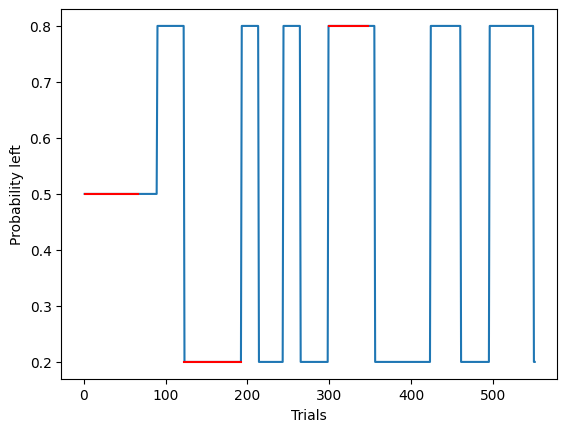

In [100]:
plot_data = new_df[['Trial', 'use_block', 'block']].drop_duplicates()
plt.plot(plot_data['Trial'], plot_data['block'])
plt.plot(plot_data['Trial'], plot_data['use_block'], color='red')
plt.xlabel('Trials')
plt.ylabel('Probability left')

In [22]:
use_data = design_matrix[var_names].copy()  # To keep the column names
use_data[var_names] = matrix_all[mat][0]

use_data['Lick count'] = gaussian_filter1d(use_data['Lick count'], sigma=1)  # TODO: how to decide on sigma here???
#plt.hist(use_data['Lick count'])
use_data['avg_wheel_vel'] = np.abs(use_data['avg_wheel_vel'])

### Trial duration

In [5]:
a = session_trials.copy()
a['trial_duration'] = a['intervals_1'] - a['intervals_0']

(0.0, 10.0)

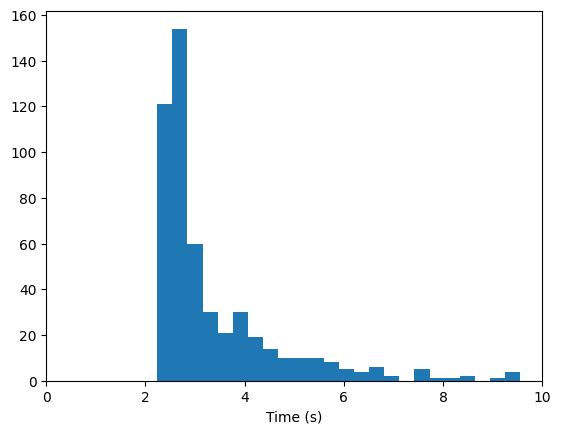

In [6]:
plt.hist(a['trial_duration'], bins=200)
plt.xlabel('Time (s)')
plt.xlim([0, 10])

## Auto-correlation

In [8]:

def cross_correlogram(x, lags_to_plot):

    # Calculate the lag values corresponding to the cross-correlation
    lags = np.arange(-lags_to_plot, lags_to_plot)

    # Compute the cross-correlation using np.correlate
    cross_correlation = np.zeros(len(lags)) * np.nan
    
    for l, lag in enumerate(lags):
        if lag < 0:
            x_chunk = np.array(x[-lag:])
            y_chunk = np.array(x[:lag])
            
        elif lag == 0:
            x_chunk = np.array(x)
            y_chunk = np.array(x)

        elif lag > 0:
            x_chunk = np.array(x[0:-lag])
            y_chunk = np.array(x[lag:])
            
        cross_correlation[l] = stats.pearsonr(x_chunk, y_chunk).statistic

    return cross_correlation


def func(t, tau, c):
    return np.exp(-t / tau) + c


## Plot correlations per feature

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_69168/3140541515.py:40: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


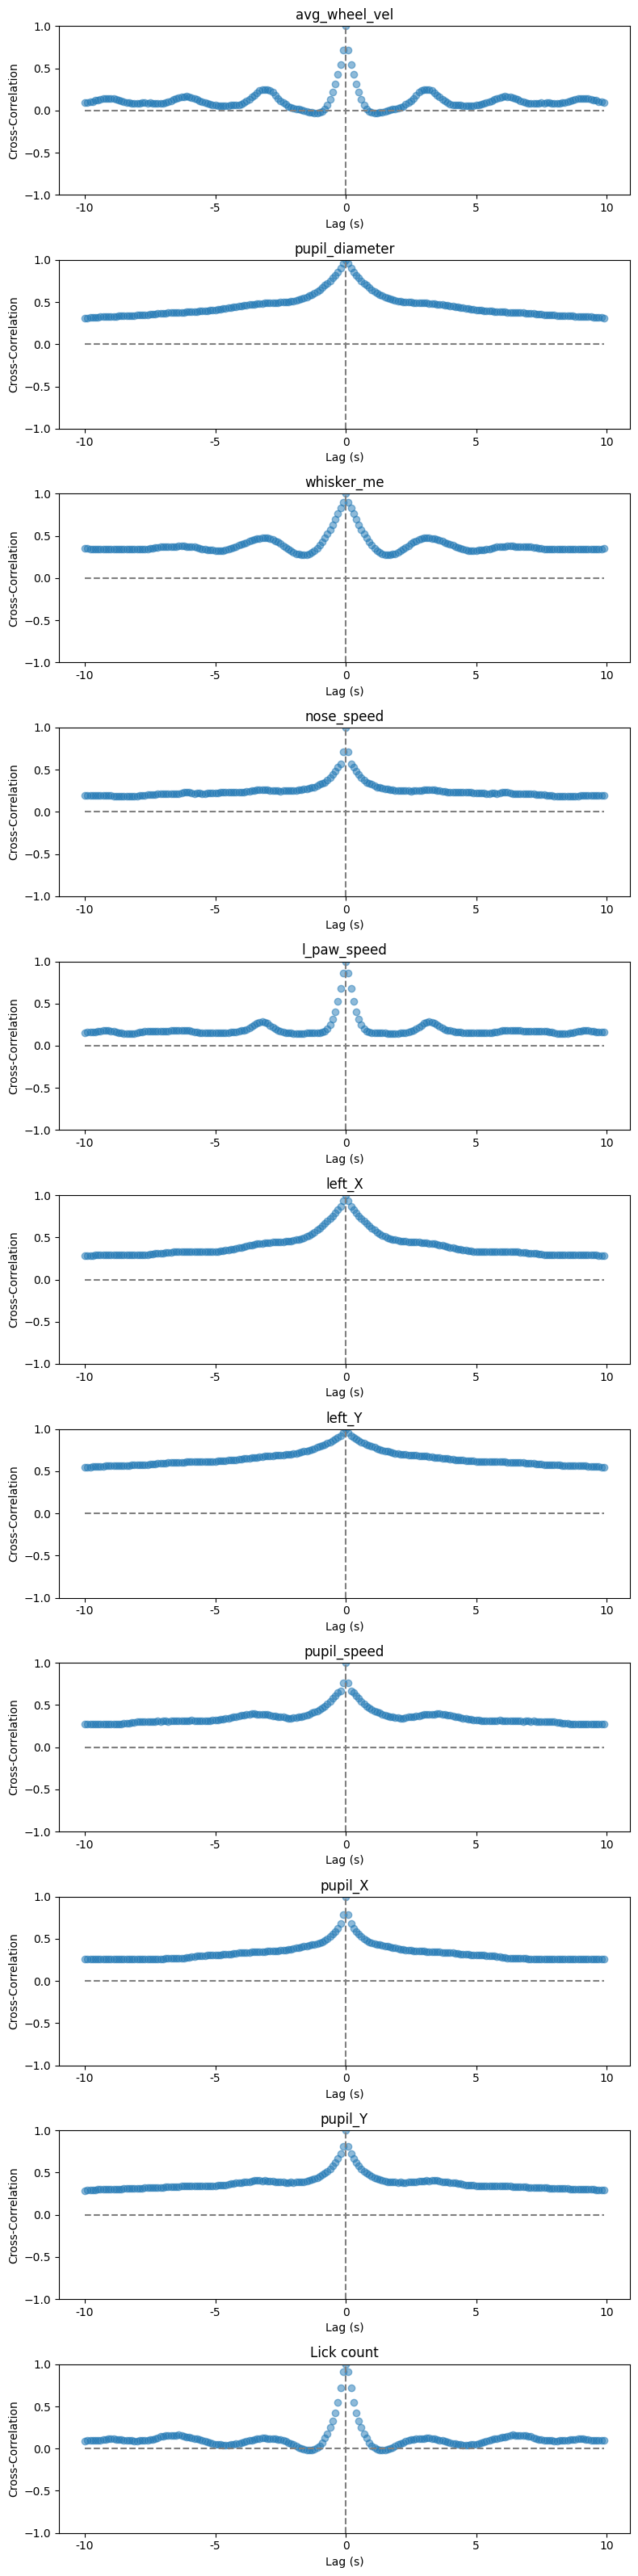

Text(0.5, 0, 'Time lag (s)')

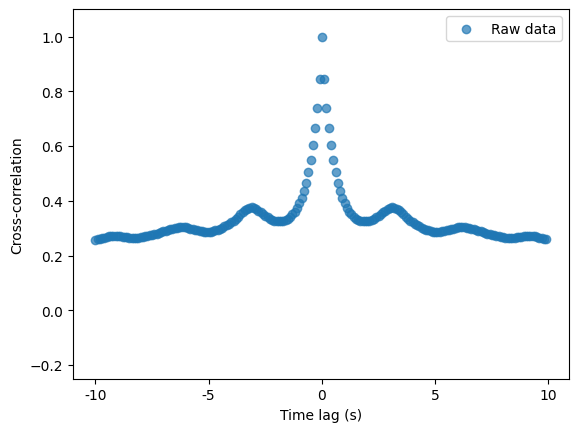

In [61]:
features = use_data.keys()
features = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

lags_to_plot = 100
lags = np.arange(-lags_to_plot, lags_to_plot)

corrs = []

fig, ax = plt.subplots(nrows=len(features) , ncols=1, sharex=False, sharey=False, figsize=[8, 32])    
# fig, ax = plt.subplots(nrows=len(features) , ncols=1, sharex=False, sharey=False, figsize=[8, 5])   
        
for i, feat in enumerate(features):
    
    x = use_data[feat]
    cross_correlation = cross_correlogram(x, lags_to_plot)

    # Save data
    if i == 0:
        corrs = [cross_correlation]
    else:
        corrs = np.vstack((corrs, cross_correlation))
        
    # Plot the cross-correlation once 
    #ax[i].scatter(lags, cross_correlation_shuf, label='Shuffled data', alpha=0.5)    
    ax[i].scatter(lags, cross_correlation, label='Raw data', alpha=0.5)
    ax[i].hlines(0, np.min(lags), np.max(lags), color='gray', linestyles='--')
    ax[i].vlines(0, -1, 1, color='gray', linestyles='--')
    ax[i].set_xlabel('Lag (s)')
    ax[i].set_ylabel('Cross-Correlation')
    ax[i].set_title(pc)
    ax[i].set_ylim([-1, 1])
    ax[i].set_xticks([-100, -50, 0, 50, 100], [-10, -5, 0, 5, 10])
    plt.tight_layout()

plt.show()
       
plt.scatter(lags, np.mean(corrs, axis=0), alpha=0.7, label='Raw data')
plt.legend()
plt.ylim([-.25, 1.1])
#plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.xticks([-100, -50, 0, 50, 100], [-10, -5, 0, 5, 10])
# Add labels and legend
plt.xlabel('Time lag (s)')
#plt.xlim([0, 35])


## Plot correlations with shuffle control

In [ ]:
features = use_data.keys()
features = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

# features = ['Lick count', 'nose_speed']

lags_to_plot = 100
lags = np.arange(-lags_to_plot, lags_to_plot)
chunk_sizes = [1, 2, 5, 10]
chunk_sizes = [1, 2, 3]
chunk_sizes = [1]

for c, chunk_size in enumerate(chunk_sizes):

    # Split the DataFrame into chunks
    chunks = [use_data.iloc[i:i + chunk_size] for i in range(0, len(use_data), chunk_size)]
    # # Shuffle each chunk independently
    # shuffled_chunks = [chunk.sample(frac=1) for chunk in chunks]
    # # Concatenate the shuffled chunks back together
    # shuffled_data = pd.concat(shuffled_chunks, ignore_index=True)

    
    shuffle_idx = np.random.permutation(np.array(chunks).shape[0])
    a = np.array(chunks)[shuffle_idx]
    b = a.reshape((np.shape(a)[0]*np.shape(a)[1], np.shape(a)[2]))
    shuffled_data = pd.DataFrame(b)

    corrs = []
    corrs_shuf = []

    if c == 0:
        fig, ax = plt.subplots(nrows=len(features) , ncols=1, sharex=False, sharey=False, figsize=[8, 32])    
        # fig, ax = plt.subplots(nrows=len(features) , ncols=1, sharex=False, sharey=False, figsize=[8, 5])   
         
    for i, pc in enumerate(features):
        
        x = use_data[pc]
        x_shuf = shuffled_data[i]

        cross_correlation = cross_correlogram(x, lags_to_plot)
        cross_correlation_shuf = cross_correlogram(x_shuf, lags_to_plot)

        # Save data
        if i == 0:
            corrs = [cross_correlation]
            corrs_shuf = [cross_correlation_shuf]
        else:
            corrs = np.vstack((corrs, cross_correlation))
            corrs_shuf = np.vstack((corrs_shuf, cross_correlation_shuf))
           
        # Plot the cross-correlation once 
        if c == 0:
            #ax[i].scatter(lags, cross_correlation_shuf, label='Shuffled data', alpha=0.5)    
            ax[i].scatter(lags, cross_correlation, label='Raw data', alpha=0.5)
            ax[i].hlines(0, np.min(lags), np.max(lags), color='gray', linestyles='--')
            ax[i].vlines(0, -1, 1, color='gray', linestyles='--')
            ax[i].set_xlabel('Lag (s)')
            ax[i].set_ylabel('Cross-Correlation')
            ax[i].set_title(pc)
            ax[i].set_ylim([-1, 1])
            ax[i].set_xticks([-100, -50, 0, 50, 100], [-10, -5, 0, 5, 10])

                    
            plt.tight_layout()
    plt.show()
    plt.scatter(lags, np.mean(corrs_shuf, axis=0), alpha=0.7, label=str(chunk_size)) 
       
plt.scatter(lags, np.mean(corrs, axis=0), alpha=0.7, label='Raw data')
plt.legend()
plt.ylim([-.25, 1.1])
#plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.xticks([-100, -50, 0, 50, 100], [-10, -5, 0, 5, 10])
# Add labels and legend
plt.xlabel('Time lag (s)')
#plt.xlim([0, 35])


## Plot autocorrelations per block

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_69168/2776412318.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


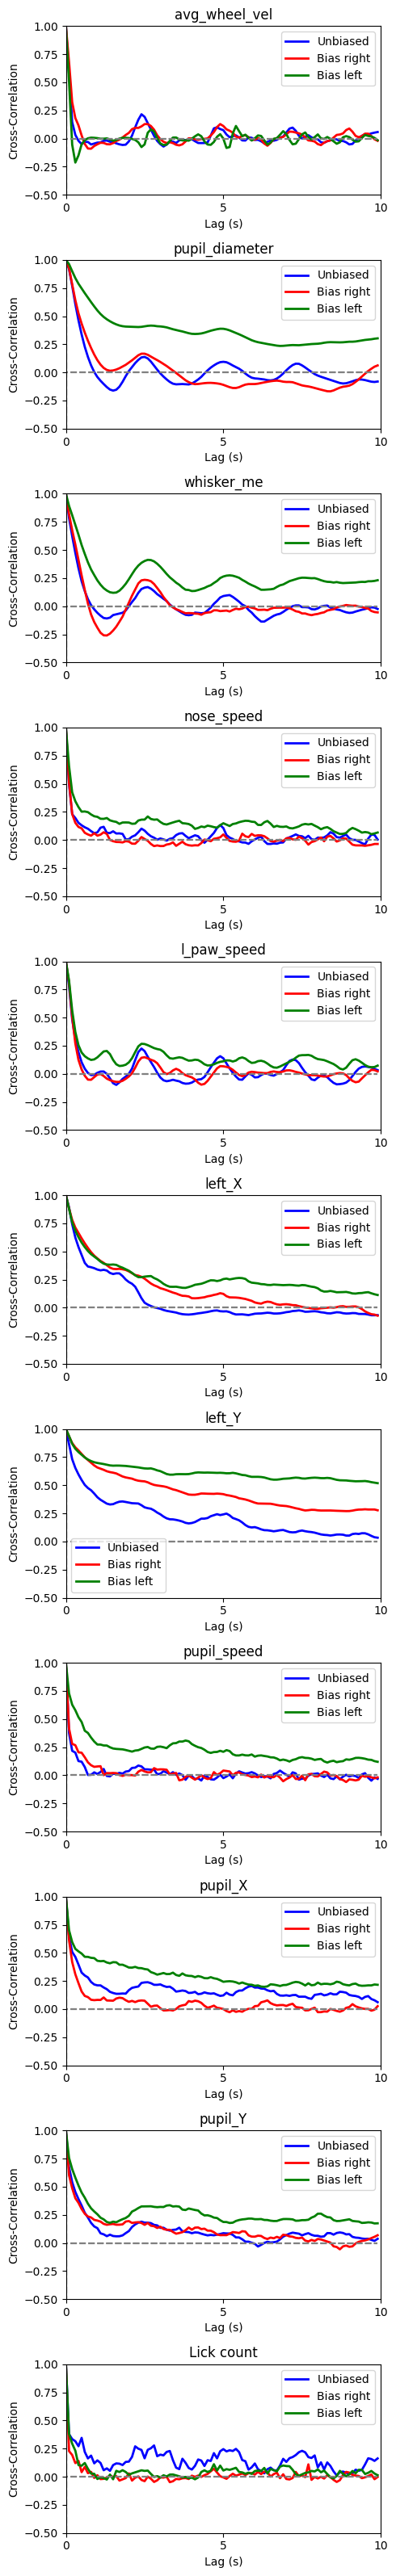

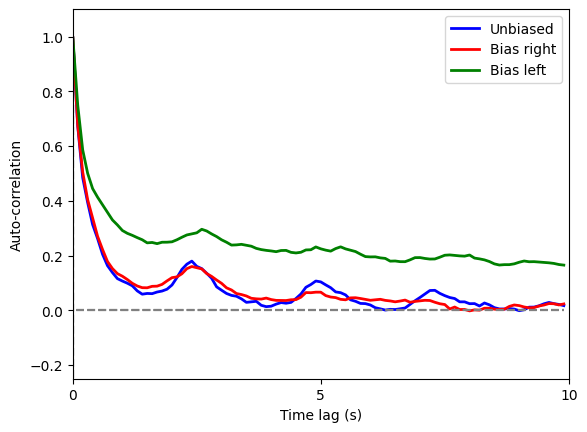

In [119]:
features = use_data.keys()
features = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']
blocks = [0.5, 0.2, 0.8]
block_colors = ['blue', 'red', 'green']
block_labels = ['Unbiased', 'Bias right', 'Bias left']
lags_to_plot = 100
lags = np.arange(-lags_to_plot, lags_to_plot)

# corrs = []

fig, ax = plt.subplots(nrows=len(features) , ncols=1, sharex=False, sharey=False, figsize=[5, 32])    
# fig, ax = plt.subplots(nrows=len,(features) , ncols=1, sharex=False, sharey=False, figsize=[8, 5])   

block_corrs = {}
for i, feat in enumerate(features):
    for b, block in enumerate(blocks):
        
        x = new_df.loc[new_df['use_block']==block, feat]
        cross_correlation = cross_correlogram(x, lags_to_plot)

        # Save data
        if i == 0:
            # corrs = [cross_correlation]
            block_corrs[block] = [cross_correlation]
        else:
            # corrs = np.vstack((corrs, cross_correlation))
            block_corrs[block] = np.vstack((block_corrs[block], cross_correlation))
        
        # Plot the cross-correlation once 
        ax[i].plot(lags, cross_correlation, linewidth=2, color=block_colors[b], 
                      label=block_labels[b])
        ax[i].hlines(0, np.min(lags), np.max(lags), color='gray', linestyles='--')
        ax[i].vlines(0, -1, 1, color='gray', linestyles='--')
        ax[i].set_xlabel('Lag (s)')
        ax[i].set_ylabel('Cross-Correlation')
        ax[i].set_title(feat)
        ax[i].set_ylim([-.5, 1])
        ax[i].set_xlim([0, 100])
        ax[i].set_xticks([0, 50, 100], [0, 5, 10])

        if b == 2:
           ax[i].legend()
        plt.tight_layout()

plt.show()

for b, block in enumerate(blocks):    
    plt.plot(lags, np.mean(block_corrs[block], axis=0), alpha=1, color=block_colors[b],
                label=block_labels[b], linewidth=2)
    plt.hlines(0, np.min(lags), np.max(lags), color='gray', linestyles='--')
    plt.vlines(0, -1, 1, color='gray', linestyles='--')
    plt.legend()
    plt.ylim([-.25, 1.1])
    #plt.xlabel('Lag')
    plt.ylabel('Auto-correlation')
    plt.xticks([0, 50, 100], [0, 5, 10])
    # Add labels and legend
    plt.xlabel('Time lag (s)')
    plt.xlim([0, 100])


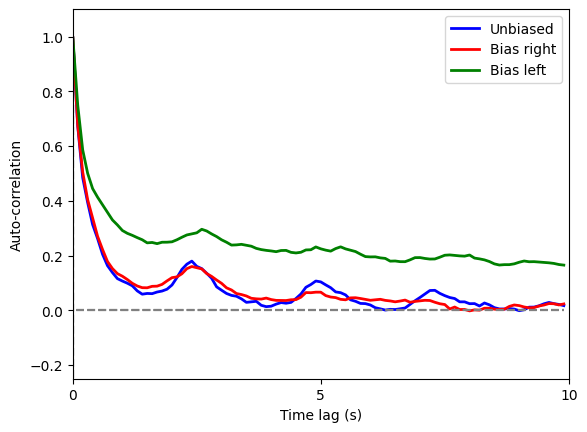

In [115]:
for b, block in enumerate(blocks):    
    plt.plot(lags, np.mean(block_corrs[block], axis=0), alpha=1, color=block_colors[b],
                label=block_labels[b], linewidth=2)
    plt.hlines(0, np.min(lags), np.max(lags), color='gray', linestyles='--')
    plt.vlines(0, -1, 1, color='gray', linestyles='--')
    plt.legend()
    plt.ylim([-.25, 1.1])
    #plt.xlabel('Lag')
    plt.ylabel('Auto-correlation')
    plt.xticks([0, 50, 100], [0, 5, 10])
    # Add labels and legend
    plt.xlabel('Time lag (s)')
    plt.xlim([0, 100])

## Fit tau

The rate at which this autocorrelogram declines in a behaving mouse may be characterized as a time-constant, tau, of an exponentially decaying curve. Tau was fit using the Levenberg-Marquardt algorithm (non-linear least squares) using the SciPy optimization package.

2.3
7.7
3.4
2.3
2.5
14.2
5.2
2.3
2.2
2.7
3.3


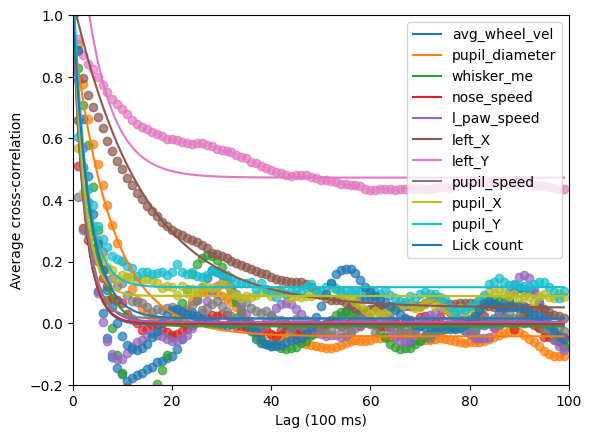

In [24]:

for v, var in enumerate(range(np.shape(corrs)[0])):
    end = 1000
    t = lags[lags_to_plot:end]
    y = corrs[v, lags_to_plot:end]


    popt, pcov = curve_fit(func, t, y)

    tau, c = popt
    y_fit = func(t, tau, c)
    
    plt.scatter(lags[lags_to_plot:end], y, alpha=0.7)
    plt.plot(lags[lags_to_plot:end], y_fit, label=features[var])
    #plt.legend(str(np.round(tau, decimals=1)))
    plt.legend()
    print(np.round(tau, decimals=1))

    plt.ylim([-.2, 1])
    plt.xlabel('Lag (100 ms)')
    plt.ylabel('Average cross-correlation')
    plt.xlim([0, lags_to_plot])
    

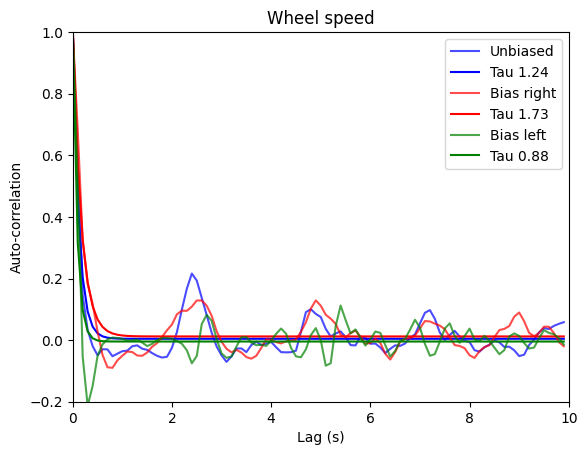

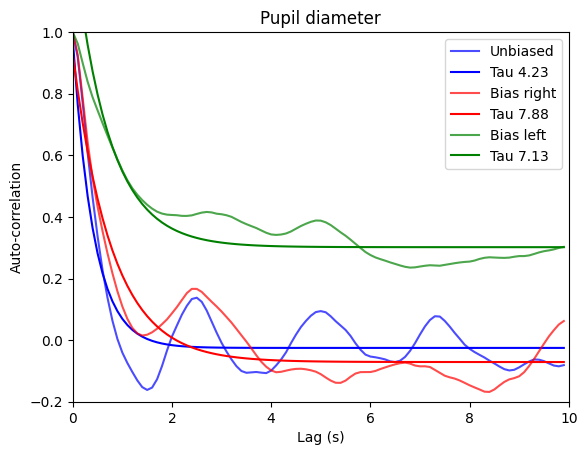

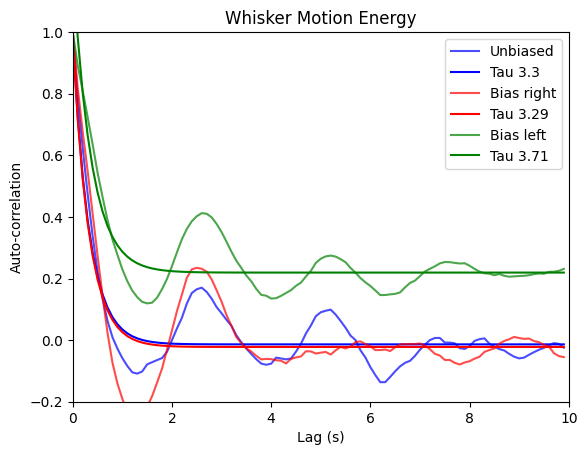

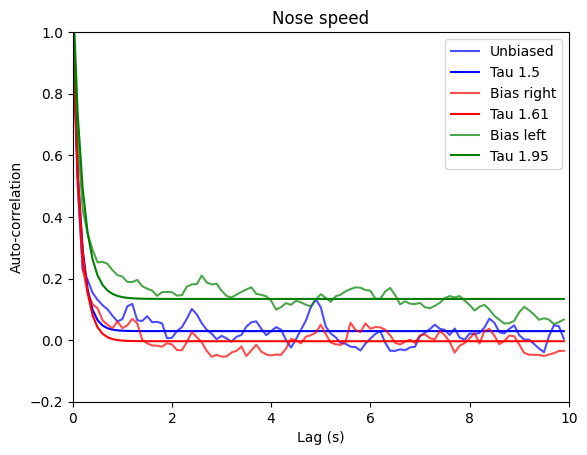

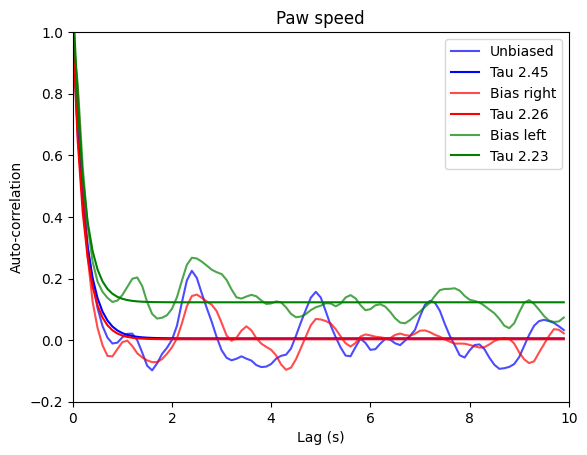

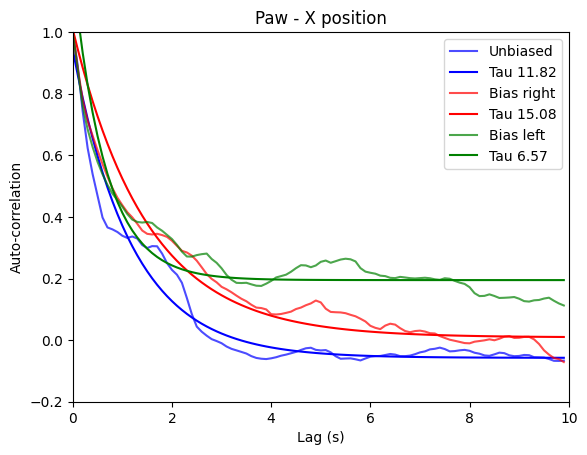

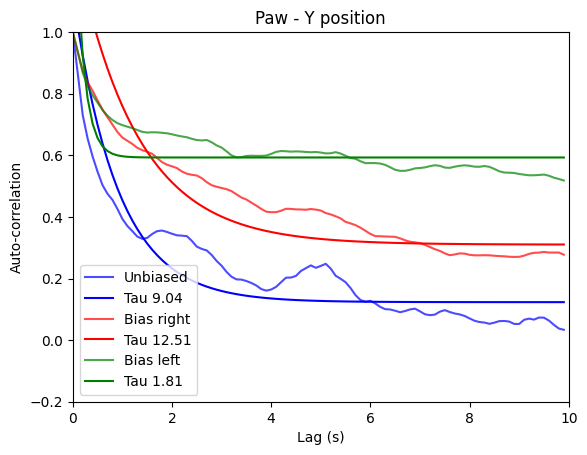

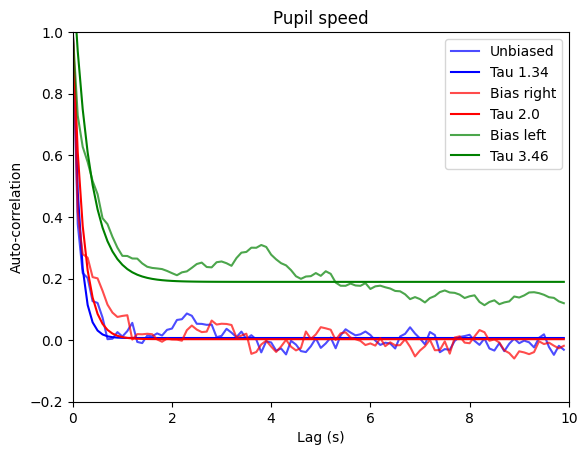

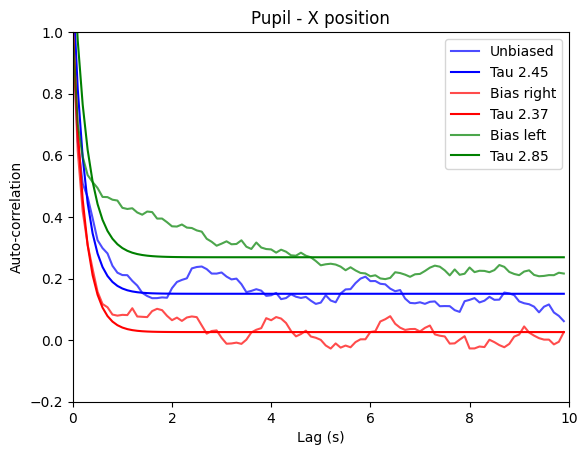

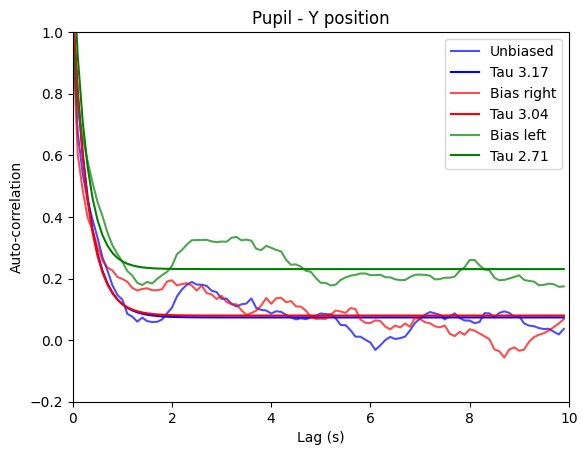

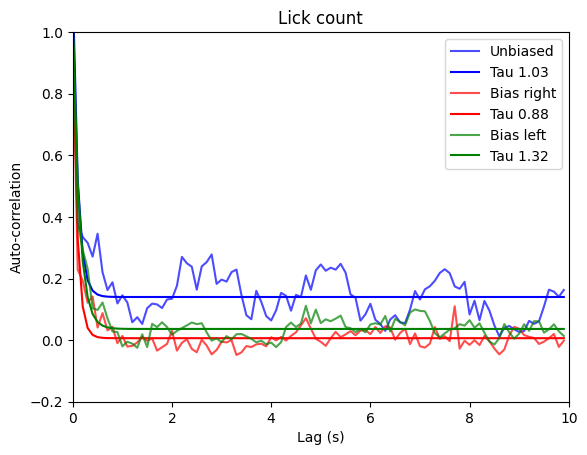

In [135]:
block_colors = ['blue', 'red', 'green']
block_labels = ['Unbiased', 'Bias right', 'Bias left']
var_names = ['Wheel speed', 'Pupil diameter',
              'Whisker Motion Energy', 'Nose speed', 'Paw speed', 'Paw - X position', 'Paw - Y position',
              'Pupil speed', 'Pupil - X position', 'Pupil - Y position', 'Lick count']
for v, var in enumerate(features):

    for b, block in enumerate(blocks):   

        use_corrs = block_corrs[block]
        end = 1000
        t = lags[lags_to_plot:end]
        y = use_corrs[v, lags_to_plot:end]

        popt, pcov = curve_fit(func, t, y)
        tau, c = popt
        y_fit = func(t, tau, c)
        
        plt.plot(lags[lags_to_plot:end], y, alpha=0.7, label=block_labels[b], color=block_colors[b])
        plt.plot(lags[lags_to_plot:end], y_fit, label=str('Tau ' + str(np.round(tau, 2))), color=block_colors[b])
        plt.legend()
        plt.ylim([-.2, 1])
        plt.xlabel('Lag (s)')
        plt.ylabel('Auto-correlation')
        plt.xticks([0, 20, 40, 60, 80, 100], [0, 2, 4, 6, 8, 10])
        # Add labels and legend
        plt.xlim([0, 100])
        plt.xlim([0, lags_to_plot])
        plt.title(str(var_names[v]))
    plt.show()


## Data per block (should move to a different notebook)

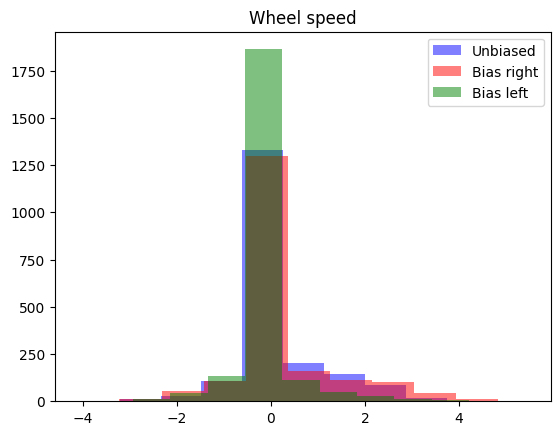

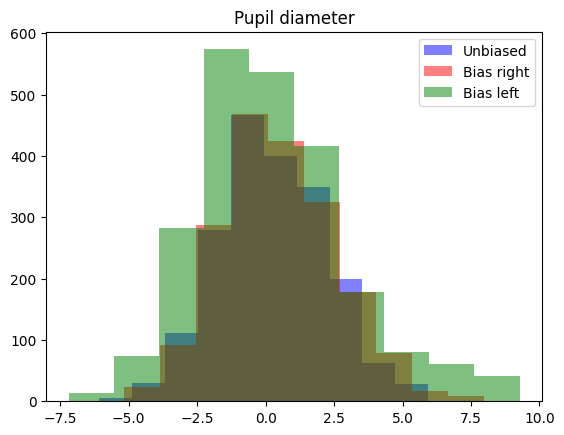

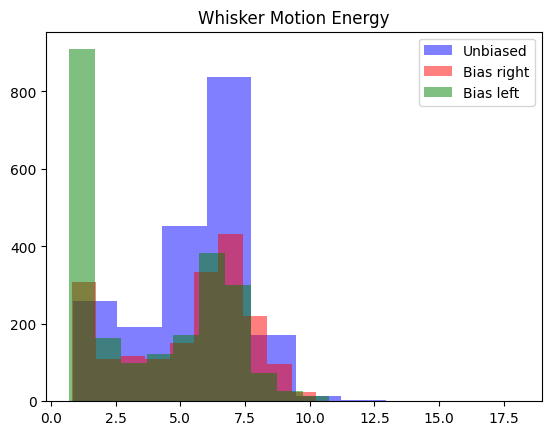

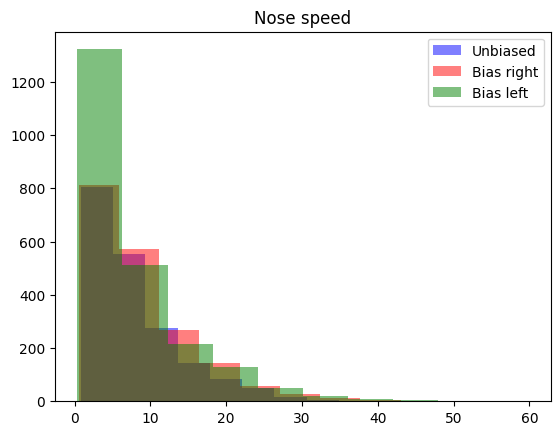

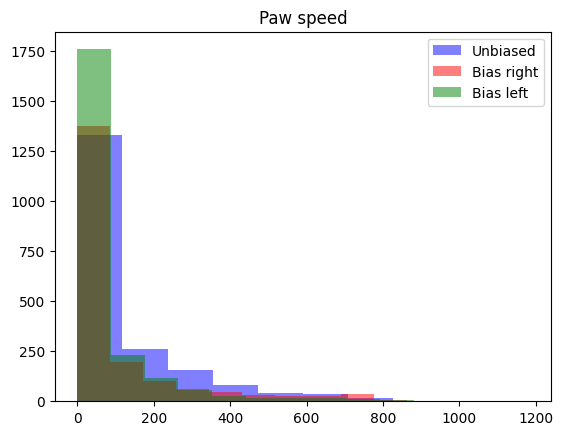

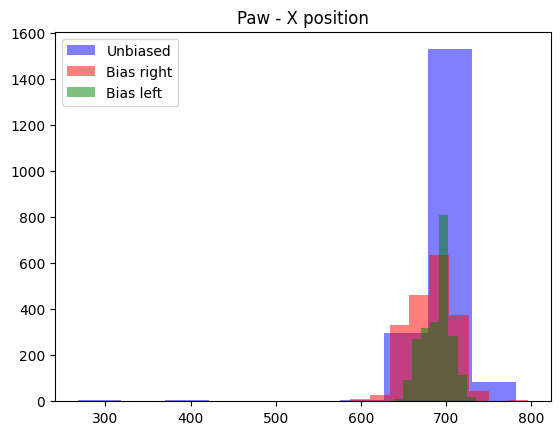

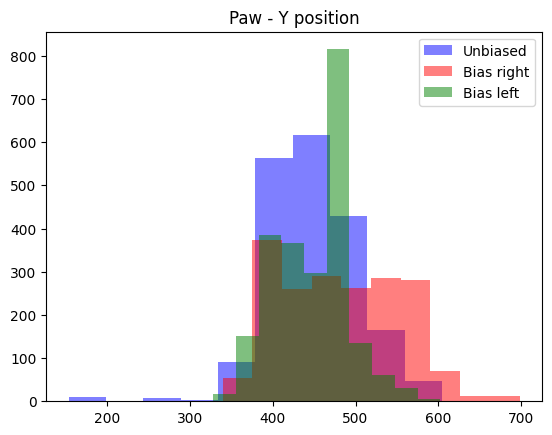

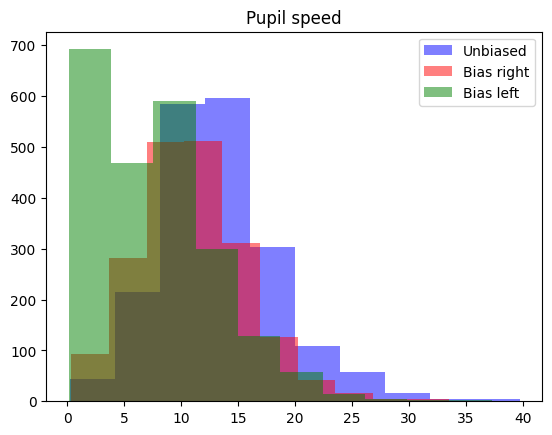

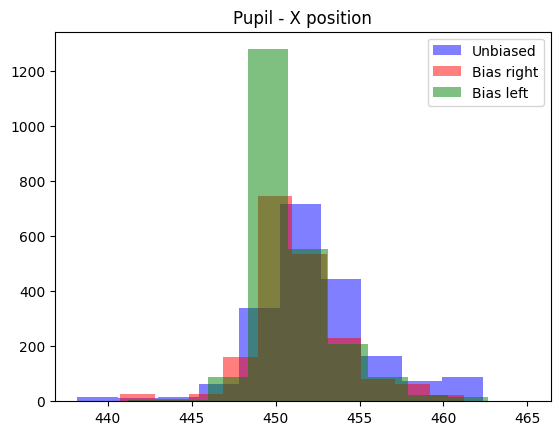

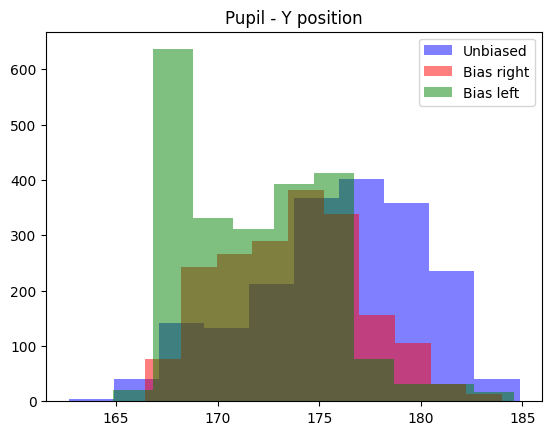

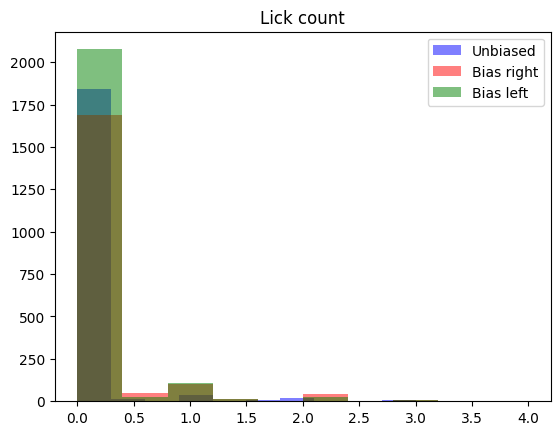

In [142]:
block_colors = ['blue', 'red', 'green']
block_labels = ['Unbiased', 'Bias right', 'Bias left']
var_names = ['Wheel speed', 'Pupil diameter',
              'Whisker Motion Energy', 'Nose speed', 'Paw speed', 'Paw - X position', 'Paw - Y position',
              'Pupil speed', 'Pupil - X position', 'Pupil - Y position', 'Lick count']
for v, var in enumerate(features):

    for b, block in enumerate(blocks):   
        
        plot_data = new_df.loc[new_df['use_block']==block, var]
        plt.hist(plot_data, alpha=0.5, label=block_labels[b], color=block_colors[b])
        plt.legend()
        # plt.ylim([-.2, 1])
        # plt.ylabel('Auto-correlation')
        # plt.xticks([0, 20, 40, 60, 80, 100], [0, 2, 4, 6, 8, 10])
        # # Add labels and legend
        # plt.xlim([0, 100])
        # plt.xlim([0, lags_to_plot])
        plt.title(str(var_names[v]))
    plt.show()

## Trial phase

In [8]:
bins_df = bins_per_trial_phase(design_matrix, session_trials)
bins_df = bins_df.rename(columns={0: 'Bin'})
new_df = design_matrix.merge(bins_df, on='Bin')
melted = pd.melt(new_df, id_vars=['Bin', 'label', 'Trial'], value_vars=np.array(new_df.keys()[1:-1]))

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:410: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:411: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:412: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:413: FutureWarning

## Auto-correlation per trial phase

In [9]:
new_df['broader_label'] = new_df['label']
new_df.loc[new_df['broader_label']=='Stimulus right', 'broader_label'] = 'Pre-choice'
new_df.loc[new_df['broader_label']=='Stimulus left', 'broader_label'] = 'Pre-choice'
new_df.loc[new_df['broader_label']=='Quiescence', 'broader_label'] = 'Pre-choice'
new_df.loc[new_df['broader_label']=='Left choice', 'broader_label'] = 'Choice'
new_df.loc[new_df['broader_label']=='Right choice', 'broader_label'] = 'Choice'
new_df.loc[new_df['broader_label']=='Correct feedback', 'broader_label'] = 'Post-choice'
new_df.loc[new_df['broader_label']=='Incorrect feedback', 'broader_label'] = 'Post-choice'
new_df.loc[new_df['broader_label']=='ITI_correct', 'broader_label'] = 'Post-choice'
new_df.loc[new_df['broader_label']=='ITI_incorrect', 'broader_label'] = 'Post-choice'

new_df['Lick count'] = gaussian_filter1d(new_df['Lick count'], sigma=1)  # TODO: how to decide on sigma here???
new_df['avg_wheel_vel'] = np.abs(new_df['avg_wheel_vel'])

In [28]:
    x =feature_label
    # Calculate the lag values corresponding to the cross-correlation
    lags = np.arange(-lags_to_plot, lags_to_plot)

    # Compute the cross-correlation using np.correlate
    cross_correlation = np.zeros(len(lags)) * np.nan
    
    for l, lag in enumerate(lags):
        if lag < 0:
            x_chunk = np.array(x[-lag:])
            y_chunk = np.array(x[:lag])
            
        elif lag == 0:
            x_chunk = np.array(x)
            y_chunk = np.array(x)

        elif lag > 0:
            x_chunk = np.array(x[0:-lag])
            y_chunk = np.array(x[lag:])
            
        cross_correlation[l] = stats.pearsonr(x_chunk, y_chunk).statistic


In [42]:
keys

dict_keys(['Pre-choiceavg_wheel_vel', 'Pre-choicepupil_diameter', 'Pre-choicewhisker_me', 'Pre-choicenose_speed', 'Pre-choicel_paw_speed', 'Pre-choiceleft_X', 'Pre-choiceleft_Y', 'Pre-choicepupil_speed', 'Pre-choicepupil_X', 'Pre-choicepupil_Y', 'Pre-choiceLick count', 'Choiceavg_wheel_vel', 'Post-choiceavg_wheel_vel'])

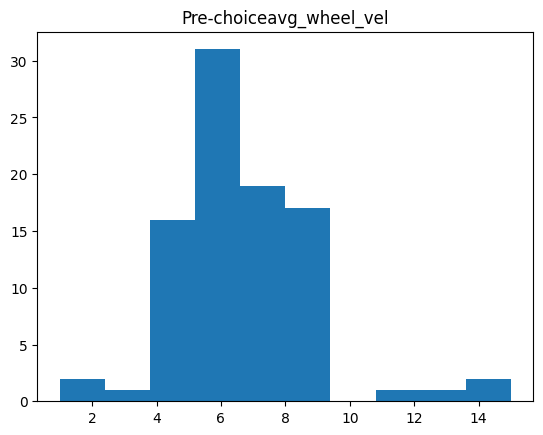

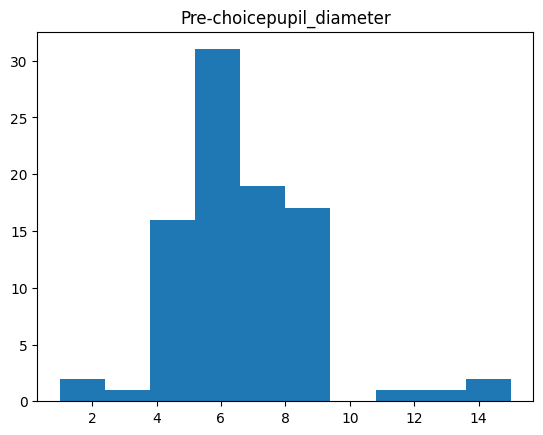

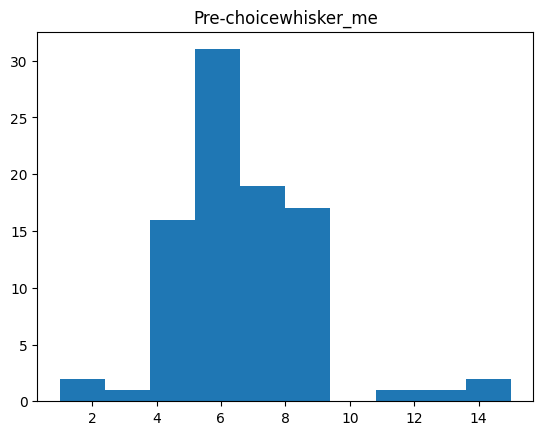

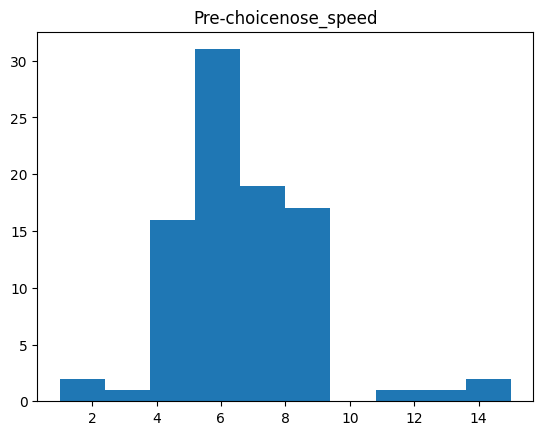

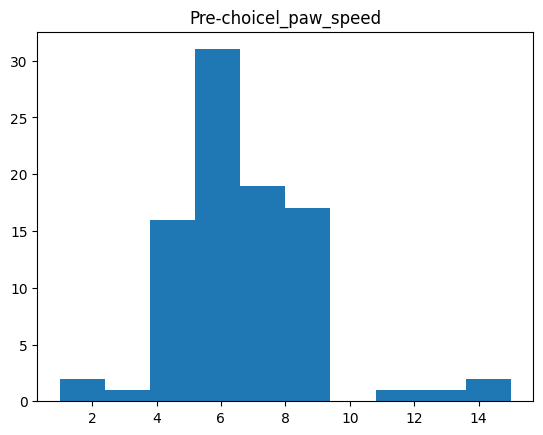

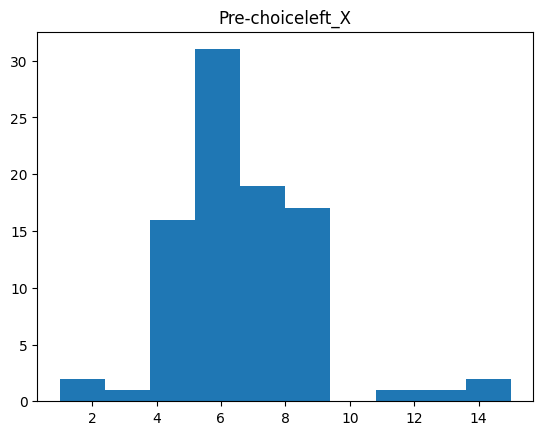

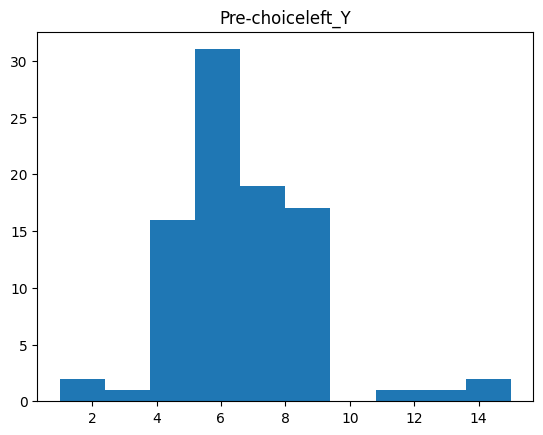

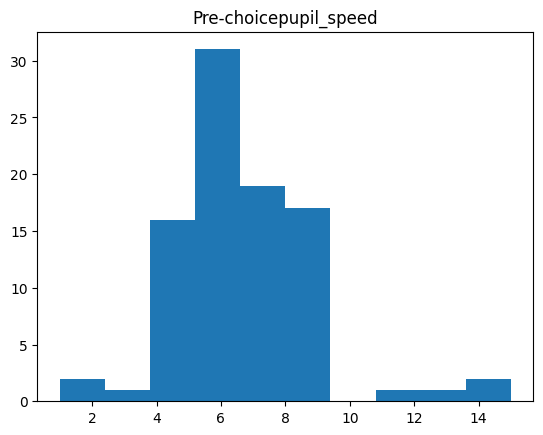

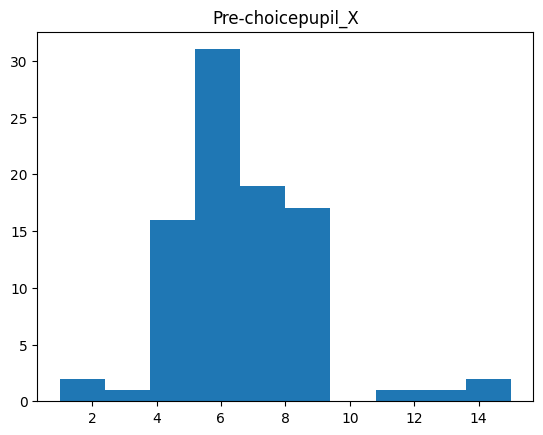

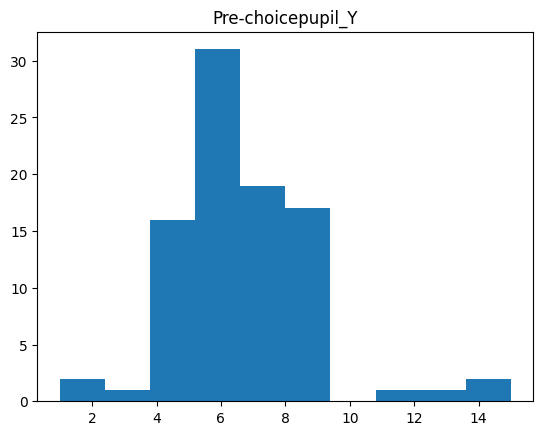

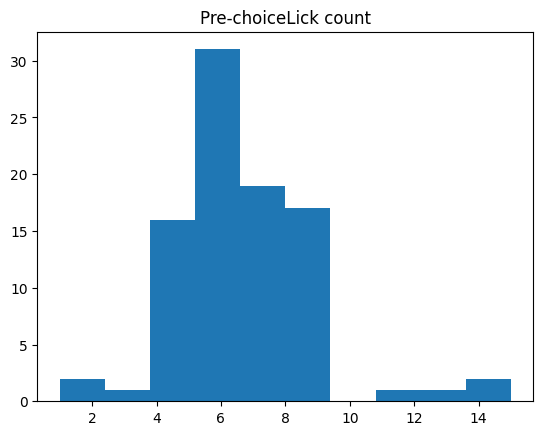

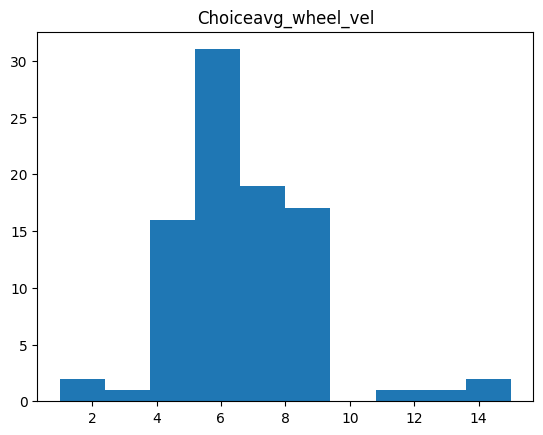

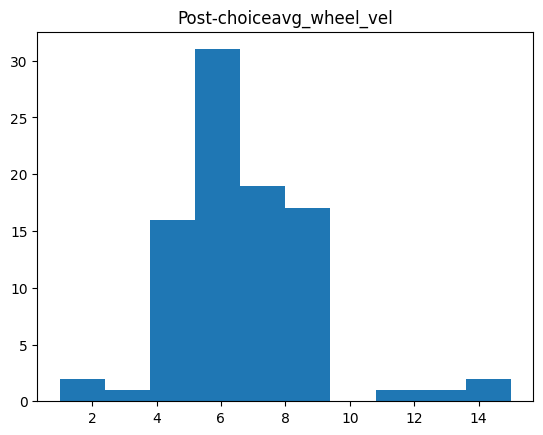

In [41]:
keys = len_label_feature.keys()

for key in keys:
    plt.hist(len_label_feature[key])
    plt.title(key)
    plt.show()

In [39]:
features = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']
labels = ['Pre-choice', 'Choice', 'Post-choice']
lags_to_plot = 2
corr_label_feature = {}
len_label_feature = {}

for label in labels:
    for feature in features:
        # Initialize 
        eid = str(label + feature)
        for trial in new_df['Trial'].unique():
            label = labels[0]
            feature_label = new_df.loc[(new_df['Trial']==trial) & (new_df['broader_label']==label), feature]
            
            # Calculate cross-correlogram 
            if 2*lags_to_plot <= len(feature_label):
                correlogram = cross_correlogram(feature_label, lags_to_plot)
                
                if trial == 0:
                    corr_label_feature[eid] = [correlogram]
                else:
                    corr_label_feature[eid] = np.concatenate((corr_label_feature[eid], [correlogram]))
            if trial == 0:
                len_label_feature[eid] = [len(feature_label)]
            else:
                len_label_feature[eid] = np.concatenate((len_label_feature[eid], [len(feature_label)]))
                    

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


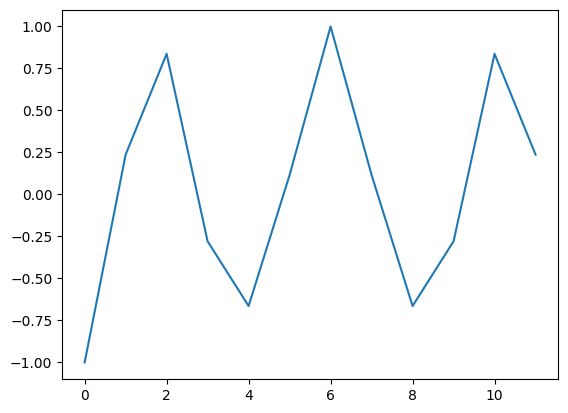

In [101]:
lags_to_plot = 
a = cross_correlogram(feature_label, lags_to_plot)
plt.plot(a)

In [99]:
a

array([ 0.23710783,  0.83691383, -0.27874393, -0.66389081,  0.11602425,
        1.        ,  0.11602425, -0.66389081, -0.27874393,  0.83691383])

In [86]:
feature_label

2469    0.253453
2470    0.058758
2471    0.058423
2472    0.242105
2473    0.399077
2474    0.246537
2475    0.112414
2476    0.300595
Name: Lick count, dtype: float64

In [66]:
# subtract_baseline can be True, False, or pupil

series_df = pd.DataFrame({'time':time, 'position':position})
onset_times = trials[event]
offset_times = trials[]
# Start a matrix with #trials x # wheel bins
time_step = np.median(np.diff(time))
interval_length = int((t_end+t_init)/time_step + .25 * 
                        (t_end+t_init)/time_step) # This serves as an estimation for size of data
series_stack = np.zeros((len(onset_times), interval_length)) * np.nan

TypeError: list indices must be integers or slices, not str

In [70]:
trials[0]

,intervals_bpod_0,intervals_bpod_1,goCueTrigger_times,stimOff_times,quiescencePeriod,contrastLeft,response_times,stimOn_times,goCue_times,firstMovement_times,...,feedbackType,choice,intervals_0,intervals_1,signed_contrast,contrast,correct_easy,correct,response,reaction
0,0.000000,3.876901,92.899239,95.582767,0.610104,1.0000,94.506751,92.899033,92.900067,93.235267,...,1.0,1.0,92.205833,96.082765,-1.0000,1.0000,1.0,1.0,1.607718,0.336233
1,4.268200,13.626002,98.761390,105.331867,0.603376,0.1250,103.247636,98.761267,98.762367,98.649267,...,-1.0,-1.0,96.474067,105.831965,-0.1250,0.1250,NaN,0.0,4.486370,-0.112000
2,14.002500,18.210002,108.277682,109.915933,0.618698,1.0000,108.832286,108.277500,108.278333,108.435267,...,1.0,1.0,106.208467,110.415999,-1.0000,1.0000,1.0,1.0,0.554786,0.157767
3,18.590200,21.426302,111.644509,113.132300,0.559975,0.0000,112.049513,111.644400,111.645300,111.872267,...,1.0,-1.0,110.796200,113.632332,0.0625,0.0625,NaN,1.0,0.405113,0.227867
4,21.793600,24.588302,114.911133,116.294300,0.674887,0.2500,115.238733,114.911000,114.911967,114.981267,...,1.0,1.0,113.999633,116.794335,-0.2500,0.2500,NaN,1.0,0.327733,0.070267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,3228.413899,3289.301501,3321.135904,3381.034933,0.423820,0.1250,3378.968603,3320.723533,3321.136867,3377.540267,...,-1.0,-1.0,3320.646900,3381.535027,-0.1250,0.1250,NaN,0.0,58.245069,56.816733
549,3290.283999,3353.440601,3383.173039,3443.250700,0.500992,0.0625,3443.174669,3383.172900,3383.173967,NaN,...,-1.0,0.0,3382.517533,3445.674693,-0.0625,0.0625,NaN,0.0,60.001769,NaN
550,3354.406799,3415.336300,3447.184205,3507.070867,0.470040,0.0000,3505.000603,3446.721700,3447.184967,3504.082267,...,-1.0,1.0,3446.640900,3507.570926,0.2500,0.2500,NaN,0.0,58.278903,57.360567
551,3416.312199,3479.333201,3509.066838,3570.819933,0.446735,0.0000,3569.068355,3509.066667,3509.067633,NaN,...,-1.0,0.0,3508.546833,3571.568378,0.0000,0.0000,NaN,0.0,60.001688,NaN


In [71]:
98.761390 + 13.626002

112.387392

In [ ]:
# def timeseries_PSTH(time, position, trials, event, t_init, t_end, subtract_baseline):
    
# subtract_baseline can be True, False, or pupil

series_df = pd.DataFrame({'time':time, 'position':position})
onset_times = trials[event]

# Start a matrix with #trials x # wheel bins
time_step = np.median(np.diff(time))
interval_length = int((t_end+t_init)/time_step + .25 * 
                        (t_end+t_init)/time_step) # This serves as an estimation for size of data
series_stack = np.zeros((len(onset_times), interval_length)) * np.nan

# Loop through trials
for t, trial_onset in enumerate(onset_times):
    
    if t < len(onset_times)-1:
        # Get next trial
        next_onset = onset_times[t+1]
    else:
        next_onset = trial_onset + t_end + 1
    
    if (np.isnan(trial_onset) == False) & (np.isnan(next_onset) == False):
        if len(series_df.loc[series_df['time'] > trial_onset, 'time']) > 0:
            
            trial_onset_index = series_df.loc[series_df['time'] > trial_onset, 
                                                'time'].reset_index()['index'][0]
            next_onset_index = series_df.loc[series_df['time'] > next_onset, 
                                                'time'].reset_index()['index'][0]
            onset_time = series_df['time'][trial_onset_index]
            next_onset_time = series_df['time'][next_onset_index]
            
            # Get time from first trial (only once to avoid the last trial)
            if t == 0:
                
                time_window = series_df.loc[(series_df['time']> trial_onset-t_init) & 
                                            (series_df['time'] <= trial_onset+t_end), 'time'] - onset_time
            
            # Subtract baseline if requested
            if subtract_baseline == True:
                onset_position = series_df['position'][trial_onset_index]
                # Populate dataframe with useful trial-aligned information
                window_values = series_df.loc[(series_df['time']> trial_onset-t_init) & 
                                            (series_df['time'] <= trial_onset+t_end), 
                                            'position'] - onset_position 
            elif subtract_baseline == False:
                window_values = series_df.loc[(series_df['time']> trial_onset-t_init) & 
                                                (series_df['time'] <= trial_onset+t_end), 'position']
                
            elif subtract_baseline == 'pupil':
                max_pupil = np.max(series_df['position'])
                min_pupil = np.min(series_df['position'])
                series_df['norm_position'] = (series_df['position']) * 100 / (max_pupil - min_pupil)  #  (series_df['position'] - min_pupil) * 100 / (max_pupil - min_pupil)
                baseline = np.mean(series_df.loc[(series_df['time'] > trial_onset-t_init) & 
                                                    (series_df['time'] < trial_onset), 'norm_position'])
                window_values = series_df.loc[(series_df['time']> trial_onset-t_init) & 
                                            (series_df['time'] <= trial_onset+t_end), 
                                            'norm_position'] - baseline 

            # Trim values of next trial
            window_values = np.array(window_values)
            time_window = np.array(time_window)
            window_values[np.where(time_window > (next_onset_time - trial_onset))] = np.nan
            series_stack[t, :len(window_values)] = window_values
                    
# Build data frame with extra info
preprocessed_trials = prepro(trials)
df_stack = pd.DataFrame(series_stack[:, :len(window_values)])
df_stack['feedback'] = preprocessed_trials['feedbackType']
df_stack['choice'] = preprocessed_trials['choice']
df_stack['contrast'] = preprocessed_trials['contrast']
df_stack['response_time'] = preprocessed_trials['response_times'] - preprocessed_trials['stimOn_times']
df_stack['feedback_time'] = preprocessed_trials['feedback_times'] - preprocessed_trials['stimOn_times']

df_melted = pd.melt(df_stack, id_vars=['feedback', 'choice', 'contrast', 
                                        'response_time', 'feedback_time'], 
                    value_vars=np.array(df_stack.keys()[1:-5]))

# Rename variable to reflect event-aligned time
df_melted['variable'] = df_melted['variable'].replace(np.arange(1, int(np.max(df_melted['variable'])+1)), 
                                                        np.array(list(time_window)[:int(np.max(df_melted['variable']))]))

    # return df_melted

In [65]:
time = new_df['Bin'] / 10
position = new_df['avg_wheel_vel']
trials = session_all[mat]
event = 'stimOn_times'


Stimulus left


ValueError: x and y must have length at least 2.

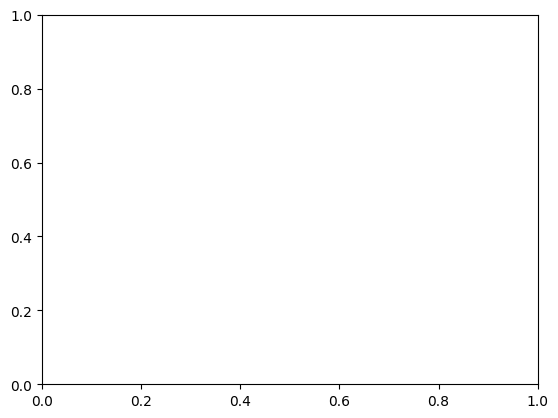

In [63]:
features = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']
epoch_type = 'broader_label'
epoch_type = 'label'
trial_epochs = new_df[epoch_type].unique()
lags_to_plot = 100


for e, epoch in enumerate(trial_epochs):
    print(epoch)
    
    fig, ax = plt.subplots()    

    use_data = new_df.loc[new_df[epoch_type]==epoch]
    use_data = use_data[features]

    for i, pc in enumerate(features):
        
        x = use_data[pc]

        # Calculate the lag values corresponding to the cross-correlation
        lags = np.arange(-lags_to_plot, lags_to_plot)

        # Compute the cross-correlation using np.correlate
        cross_correlation = np.zeros(len(lags)) * np.nan
        
        len_timeseries = len(x)
        for l, lag in enumerate(lags):
            if lag < 0:
                x_chunk = np.array(x[-lag:])
                y_chunk = np.array(x[:lag])

            elif lag == 0:
                x_chunk = np.array(x)
                y_chunk = np.array(x)

            elif lag > 0:
                x_chunk = np.array(x[0:-lag])
                y_chunk = np.array(x[lag:])
                
            cross_correlation[l] = stats.pearsonr(x_chunk, y_chunk).statistic
            
        # Save data
        if i == 0:
            corrs = [cross_correlation]
        else:
            corrs = np.vstack((corrs, cross_correlation))
            
        # Plot the cross-correlation once 
        plt.scatter(lags, cross_correlation, label='Raw data', alpha=0.5)
        plt.hlines(0, np.min(lags), np.max(lags), color='gray', linestyles='--')
        plt.vlines(0, -1, 1, color='gray', linestyles='--')
        plt.xlabel('Lag (s)')
        plt.ylabel('Cross-Correlation')
        # ax[i].set_title(pc)
        plt.ylim([-1, 1])
        # ax[i].set_xticks([-100, -50, 0, 50, 100], [-10, -5, 0, 5, 10])

                    
        plt.tight_layout()
    plt.show()
        
    plt.scatter(lags, np.mean(corrs, axis=0), alpha=0.7, label='Raw data')
    plt.legend()
    plt.ylim([-1.1, 1.1])
    #plt.xlabel('Lag')
    plt.ylabel('Cross-correlation')
    plt.title(epoch)
    plt.xticks([-100, -50, 0, 50, 100], [-10, -5, 0, 5, 10])
    # Add labels and legend
    plt.xlabel('Time lag (s)')
    #plt.xlim([0, 35])
